In [3]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp

In [146]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

kx=0.

mu=1.8
m=.5
t=1
alR=0.3
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=2     #looped
kF=np.sqrt(2*m*mu)

a=1/np.sqrt(2*m*t)
al=alR/a

delta=.5
phi=np.pi-0.0001    #looped
def delL(phi):
    return delta*cmath.exp(1j*phi/2)
def delR(phi):
    return delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL
#def TT(B):
#    return -mut(0)+np.sqrt(t**2+B**2)

GammaL=np.pi*nu0*tL**2 #=m*tL**2/2
GammaR=np.pi*nu0*tR**2 #=m*tR**2/2

NJ=5

ET=np.pi/2*kF/m/(NJ*a)

print(GammaL,delta,ET)

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

(1.0, 0.5, 0.8429777677248872)


In [147]:
#Junction
def HJ0(kx):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx):
    start=cmm(HJ0(kx))
    HJs=start
    for n in range(2,NJ+1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx):
    return En*np.eye(4*NJ)-HJ(kx).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

def fL(En,kx):
    return 1/(kF*a)*(cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF+kx)))+cmath.log(1-cmath.exp(-a/xiE(En)+1j*a*(kF-kx))))-1j

def gSC1m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delL(phi)*tP - np.conj(delL(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

def gSC2m1(En,kx,phi):
    return 1/(np.pi*nu0*abs(fL(En,kx))**2)*((En*eye4 - delR(phi)*tP - np.conj(delR(phi))*tM)*\
                                                 fL(En,kx).imag/cmath.sqrt(delta**2 - En**2) - fL(En,kx).real*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx,phi):
    return scipy.linalg.block_diag(gSC1m1(En,kx,phi),gJm1(En,kx),gSC2m1(En,kx,phi))+mHt.toarray()

In [160]:
M=50
Barray=np.linspace(0,3,M+1)
#Barray1=np.ndarray.tolist(np.linspace(3.2,3.3,20))
#Barray2=np.ndarray.tolist(np.linspace(9.15,9.45,40))
#Barray3=np.ndarray.tolist(np.linspace(2.9,3.1,30))
#Barray=np.asarray(Barray1+Barray2)#+Barray3)
#M=len(Barray)-1

#phi scanning
NP=100
ppk=np.linspace(0,2*np.pi,NP+1)

PDphi=np.zeros((M+1,2))

En=0
zerogap=0.0000001

for qq in range(M+1):
    B=Barray[qq]
    print(qq)
    detppk=[np.linalg.det(Gtotm1(0,0,ppk[j]))/(mu**(4*(NJ+0))) for j in range(len(ppk))]
    selectsmall=[x for x in detppk if np.real(x)<2] #variable input to exclude the horizontal graphics
    if selectsmall==[]:
        ekxphi=[np.pi,np.pi]
    elif selectsmall==[selectsmall[0]]*len(selectsmall):
        ekxphi=[np.pi,np.pi]
    else:
        firstminPhiB=ppk[np.argmin(selectsmall)]
        secondPhiB=(-firstminPhiB)%(2*np.pi)
        if secondPhiB==firstminPhiB:
            secondPhiB=2*np.pi
        ekxphi=[firstminPhiB,secondPhiB]
    PDphi[qq]=np.asarray(ekxphi)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


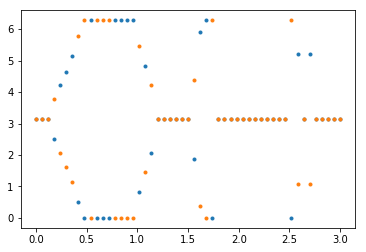

In [161]:
for p in range(len(PDphi[0])):
    pp.plot(Barray,PDphi[:,p],'.')
#pp.plot(3.26,np.pi,'*')
#pp.plot(9.26,np.pi,'*')
#pp.axis([3.1,3.5,2.5,3.7])

In [166]:
Barray[35]

2.1

In [167]:
B=Barray[35]
ppk=np.arange(100)*2*np.pi/100
detppk=[np.linalg.det(Gtotm1(0,0,ppk[j]))/(mu**(4*(NJ+0))) for j in range(len(ppk))]
ppk[np.argmin(detppk)]

0.0

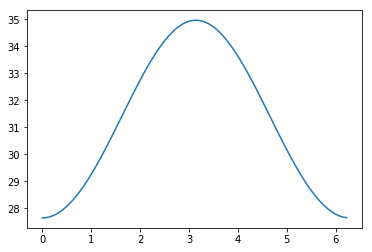

In [168]:
pp.plot(ppk,detppk)
#pp.plot(ppk,np.zeros(len(ppk)))
#pp.axis([0,2*np.pi,14.404552594406,14.404552594406+10**-12])

In [100]:
detppk

[(14.404552594406223-1.4022123131506772e-18j),
 (14.404552594406228-2.9985498655750914e-16j),
 (14.404552594406224+1.9990332437167278e-16j),
 (14.40455259440622+5.997099731150183e-16j),
 (14.404552594406224+1.9990332437167278e-16j),
 (14.40455259440622+0j),
 (14.404552594406214+3.9980664874334556e-16j),
 (14.40455259440622+3.9980664874334556e-16j),
 (14.404552594406217+7.996132974866911e-16j),
 (14.404552594406217+0j),
 (14.40455259440622+7.996132974866911e-16j),
 (14.404552594406223-2.398839892460073e-15j),
 (14.404552594406223+7.996132974866911e-16j),
 (14.40455259440622-3.1984531899467645e-15j),
 (14.404552594406224-2.398839892460073e-15j),
 (14.404552594406224+7.996132974866911e-16j),
 (14.40455259440622-2.398839892460073e-15j),
 (14.40455259440622+1.5992265949733822e-15j),
 (14.404552594406217+7.996132974866911e-16j),
 (14.40455259440622-7.996132974866911e-16j),
 (14.404552594406217-1.5992265949733822e-15j),
 (14.404552594406223-3.1984531899467645e-15j),
 (14.404552594406223+0j),


In [70]:
detppk=[0.0012,0.00123+1j,0.00124]

In [77]:
selectreal=[round_sig(x,2) for x in detppk if x==np.real(x)]

In [80]:
selectreal==[selectreal[0]]*len(selectreal)

True

In [76]:
def round_sig(x, sig=2):
    return round(x, sig-int(floor(np.log10(abs(x))))-1)

In [81]:
round_sig(123654,4)

123700.0